## 26th International Conference on Artificial Neural Networks (ICANN)
### Authors: Jordi Ysard, Sock Low, Joeri v Wijngaarden
#### Date: Feb 23rd 2016

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.ndimage.filters as fi
#from theanoCortexLib import kernel2connection, gkern2
from topologyLib import *
from time import time
import scipy.io
mat = scipy.io.loadmat('queen.mat')

%matplotlib inline

## Initialize network

(15027, 100, 2)
(1, 100)
[[44100]]
(1, 15027)
2.26757369615e-05
8.63607960276e-14
[[  1.50340136e-02   1.90249433e-02   2.30158730e-02 ...,   5.99747619e+01
    5.99787528e+01   5.99827438e+01]]


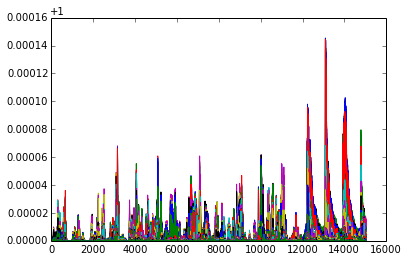

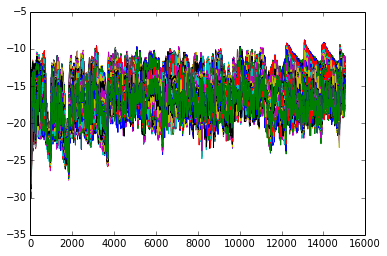

In [2]:
print mat['S'].shape
print mat['f'].shape
print mat['fs']
print mat['t'].shape

real_input = mat['S'][:,:,0]#/0.00015
dT=1./mat['fs'][0][0]
print dT
times = np.around(mat['t'],3)[0]
print real_input.min()
print mat['t']

plt.plot(real_input+1)
plt.show()
plt.plot(np.log(real_input))
plt.show()





In [3]:
def normalizeInput(inp,means, alpha, std):
    inp[np.isfinite(inp) == False] = 0
    
    means = means*(alpha)+(1-alpha)*inp
    
    std = np.sqrt(np.power(std,2)*(1-alpha)+np.power(inp-means,2)*alpha)
    inp = 0.5 + 0.5*np.tanh((inp-means)/(std))#np.sqrt(2))
    inp *=inp# np.log(inp)
    inp -= np.min(inp)
    inp /= np.max(inp)

    inp[np.isfinite(inp) == False] = 0
    return inp,means,std



In [4]:
# Need to tune for width and intensity too
def generateMovingFFT(F, iteration, direction, sigma, intensity, noise=0.2, size = 15):
    aux1 = 1#(1/(sigma*np.sqrt(2*np.pi)))
    x = np.array(range(size))
    res = aux1*np.exp(-np.power(x-F,2)/(2.*(np.power(sigma,2))))
    res = res + (np.random.rand(size)-0.5)*noise+noise/2
    x=res 
    #plt.plot(res)
    #plt.show()
    
    #print it%14<12
    if False:#iteration%14<12:
        j=int(iteration%12)/2
        aux1 = (1/(sigma*np.sqrt(2*np.pi)))
        x = np.array(range(size))
        res = aux1*np.exp(-np.power(x-(F+int(direction*j)),2)/(np.power(sigma,2)))#/float(2*s1)
        res = res + (np.random.rand(size)-0.5)*noise+noise/2
        x=res
        #for i in np.array(range(3))-1:
        #    n = min(max(F+i+int(direction*j), 0),size-1)
        #    x[n]=1-0.3*abs(i)
    #print x
    return x#.reshape(size,1)
def randomPoissonGenerator(N=800,I=0.03,P=0.2):
    I_poisson = np.zeros(N)
    idx = np.where(np.random.rand(N)<P)[0]
    I_poisson[idx] = I
    return I_poisson


    
    
#randomPoissonGenerator()

(9, 9)
Remember to always check how is the kernel!!!


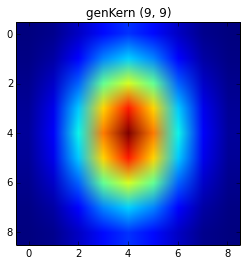

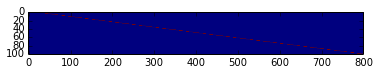

[info] Kernel shape: (9, 9)
[info] Connection Matrix shape: (100, 800)
4.5
10.0
shape: (9, 20)
here!!!!!


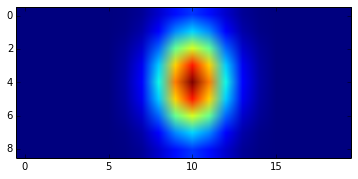

shape: (180,)


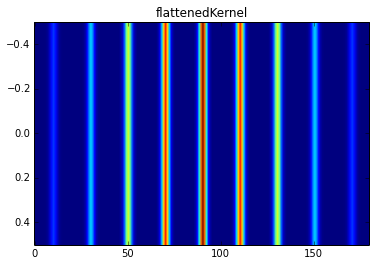

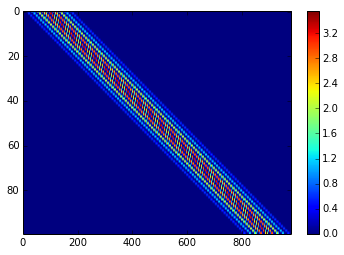

800
Down!!!!!!!!!!!!!!!!!!1
[info] Shape was fit from (100, 979) to (100, 800)


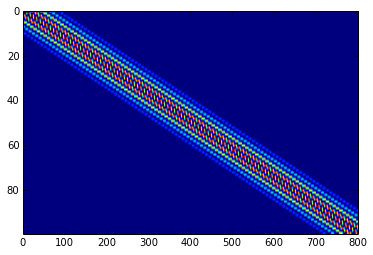

(100, 800)
asd


In [304]:
#Neurons
Ne_x = 40
Ne_y = 20
Ne   = Ne_x*Ne_y  #Excitatory neurons
Ni_x = 20
Ni_y = 10
Ni   = Ni_x*Ni_y  #Inhibitory neurons
Nt   = Ne+Ni      #Total

Re = np.random.rand( Ne ) #Single column
Ri = np.random.rand( Ni ) #Single column
#Paramaters
K = 9.*20*.36#.4*20*9. #Input scaling param

#a= timescale of recovery variable u (smaller = slower recovery). Typical=.02
a = .02*np.ones( Ne )   
a = np.append( a , (.02+.08*Ri) )

#b= sensitivity of recovery variable u to subthreshold fluctuations of v. Typical=.2
b = .2*np.ones( Ne ) 
b = np.append( b , (.25-.05*Ri) )

#c= After-spike reset value of membrane potential v. Typical=-65
c = -65+15*Re**2
c = np.append( c , -65*np.ones( Ni ))

#d= After-spike reset value of recovery variable u. Typical=2
d = 8-6*Re**2
d = np.append( d , 2*np.ones( Ni ))

#Connectivity matrix S (input->E)
N_shape    = (Ne_x,Ne_y)  #Shape of excitatory population
i_shape    = (100,1)      #Shape of input signal
kern_shape = (9,9)        #Shape of kernel
sigma      = [5,5]        #Width of kernel
kern1      = gkern2( kern_shape,sigma )
S  = kernel2connection( kern1,i_shape,N_shape )
np.save('S.npy',S)
print S.shape
print 'asd'

'''inp = np.zeros(i_shape)
inp[2]+=1
print (np.dot(S.T,inp.reshape(i_shape[0]*i_shape[1],1))).shape, N_shape
plt.imshow(np.dot(S.T,inp.reshape(i_shape[0]*i_shape[1],1)).reshape(N_shape,order='c'))
'''

S /= np.sum(S,1).reshape(( S.shape[0],1 ))*i_shape[0]
if np.sum( S,1 )[0] != 1:
    S /= np.sum( S,1 ).reshape(( S.shape[0],1 ))

#Connectivity matrix W (E<->I)
W1 = 0.*np.random.rand( Ne,Ne )
W3= 0.4*np.ones((Ni,Ne))+0.2*np.random.rand( Ni,Ne )#np.random.rand( Ni,Ne )
W4= 0.4*np.ones((Ne,Ni))+0.1*np.random.rand( Ne,Ni )#np.random.rand( Ne,Ni )
W2 = 0.*np.random.rand( Ni,Ni )
WW1  = np.concatenate( (W1,W3) , axis=0 )
WW2  = np.concatenate( (W4,W2) , axis=0 )
W  = np.concatenate( (WW1,WW2) , axis=1 )
not_identity = (np.identity( Nt )==0)  #Non-identity matrix
W = W*not_identity  #Remove self-excitation


# Normalizing the input
means = np.zeros(i_shape)
std = np.zeros(i_shape)
tau_input = 0.8


#Add STDP
STDP_m   = np.zeros( (Nt,Nt) )  #Pre-synaptic component
STDP_p   = np.zeros( (Nt,Nt) )  #Post-synaptic component
copy_m   = STDP_m
copy_p   = STDP_p
tau_plus = 7.5          #Post-spike window
tau_min  = 15.          #Pre-spike window
a_plus   = .01        #Increment for P (.0045 * 1.05 gives good values)
a_min    = a_plus*2  #Decrement for M


#Initialization
v = -65*np.ones(Nt)
u = b*v
firings=[[],[]]

W_start = W

In [305]:
#Starting simulation
time = 3000 #in ms
dt   = 1    #in ms
spikeMat = np.zeros( (Nt,time) )
stdp_neuron = np.zeros( (time,3) ) 
freqs = [20,40,60, 80]
bandwiths = [2,3,4,5]
firings=[[],[]]
W# = np.load('W_stdp_10s.npy')
W2save = np.zeros( (20,1000,1000) )
cc=1
f=0
noise=0.25 ## THIS IS THE AUDITORY NOISE
inp_intensity=.6
inp_sigma = 2 ## SIGMA FOR THE INPUT
inp_direction=0 #NOT USED RIGHT NOW
T=600 #Trial
off=200 # offset
p_E=0.
E=np.zeros(time)
E_input=np.zeros(time)
E=np.zeros(time)
E_total_log = np.zeros(time)
t_act=0

E_total_input = 5
E_total_network = 0
weight_sum = np.zeros(time)
for i in range(time):
    
    if i%T==0:
        W2save[cc,:]=W
        c +=1
    
    if i/1000. > times[t_act+1]:
        t_act+=1
        #print t_act
    stim = real_input[t_act][:]#real_input[t_act][:] #np.log(real_input[t_act][:])
    stim, means, std = normalizeInput(stim.reshape(i_shape), means, tau_input, std)
    #stim = np.tanh(stim)
    
    

    
    
    #Transform to input for all exc. neurons
    I_stim = np.sum( stim.T*S.T,axis=1 )
    #I_stim = .03*np.random.rand(Ne)
    # Normalize input energy
    E_input[i]=np.sum(np.power(I_stim,2))
    E_noise = 10.*prob*Ne/K#10.*prob*Ne/K#E_total_input-E_input[i]#P*I*N # to ignore normalization set to prob*Ne/(K*K)
    prob=0.2
    I_noise = randomPoissonGenerator(N=Ne,P=0.2,I=E_noise*K/(prob*Ne))
    E_total_log[i]=E_input[i]+E_noise
    #Current
    
    I_in = I_stim*K  +I_noise##THE POISSON IS HERE #Input to excitatory
    I_in = np.append( I_in , np.zeros( Ni )+randomPoissonGenerator(N=Ni,P=0.1,I=1.) )#Input to inhibitory

    #Check for spikes
    fired = np.where(v>=30.)[0] #indices of spikes
    
    #Update STDP matrices
    STDP_p[:,fired] += a_plus/tau_plus  #Pre-synaptic
    STDP_m[fired,:] -= a_min/tau_min   #Post-synaptic 
    
    #Record spikes
    if i>0:
        firings[0] = ( np.concatenate(( firings[0] , i*np.ones( len(fired)))  )) 
        firings[1] = ( np.concatenate(( firings[1] , fired )) ) 
        spikeMat[fired,i] = 1.
    
    #Fired
    v[fired] = c[fired]             #Reset membrane potential
    u[fired] = u[fired] + d[fired]  #Increase membrane recovery
    
    #Apply current
    #I_in += np.sum( W[:,fired] , axis=1 )
    I_in += np.sum( W[:,fired[fired<800]] , axis=1 )
    I_in -= np.sum( W[:,fired[fired>=800]] , axis=1 )
    
    
    #Mask STDP
    mask = (STDP_p!=0)*(STDP_m!=0)
    
    
    #Update W based on STDP    
    W = W + (copy_p+copy_m)*mask
    weight_sum[i]=np.sum(np.sum(W[:800,:800]))
    
    #Make copy
    copy_p = np.copy(STDP_p)
    copy_m = np.copy(STDP_m)
    
    #Apply limits
    W[W>.5] = .5  #Upper boundary
    W[W<0]  = 0.  #Lower boundary
    STDP_p[STDP_p<1.5e-5] = 0
    STDP_m[STDP_m<1.5e-5] = 0
    
    #Decay of M/P
    STDP_p = STDP_p - (1/tau_plus)*STDP_p
    STDP_m = STDP_m - (1/tau_min)*STDP_m
    
    #Record 1 neuron
    #stdp_neuron[i,0] = STDP_p[114][755]
    #stdp_neuron[i,1] = STDP_m[114][755]
    #stdp_neuron[i,2] = W[114][755]
    
    #Update v&u
    v = v+0.5*(0.04*v**2+5*v+140-u+I_in)
    v = v+0.5*(0.04*v**2+5*v+140-u+I_in)
    u = u+a*(b*v-u)
    E[i] = np.sum(np.power(v[:800],2))-np.sum(np.power(v[-800:],2))
    p_E=E[i]
    if i%100==0:
        print "Simulated time = %dms" %i

Simulated time = 0ms
Simulated time = 100ms
Simulated time = 200ms
Simulated time = 300ms
Simulated time = 400ms
Simulated time = 500ms
Simulated time = 600ms
Simulated time = 700ms
Simulated time = 800ms
Simulated time = 900ms
Simulated time = 1000ms
Simulated time = 1100ms
Simulated time = 1200ms
Simulated time = 1300ms
Simulated time = 1400ms
Simulated time = 1500ms
Simulated time = 1600ms
Simulated time = 1700ms
Simulated time = 1800ms
Simulated time = 1900ms
Simulated time = 2000ms
Simulated time = 2100ms
Simulated time = 2200ms
Simulated time = 2300ms
Simulated time = 2400ms
Simulated time = 2500ms
Simulated time = 2600ms
Simulated time = 2700ms
Simulated time = 2800ms
Simulated time = 2900ms


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


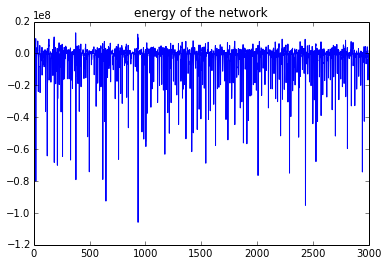

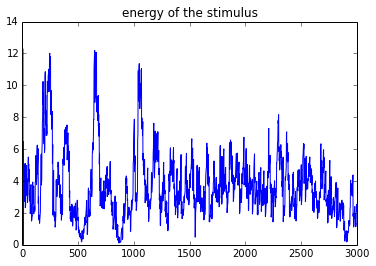

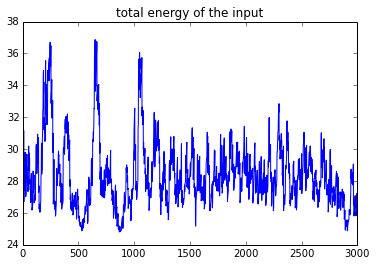

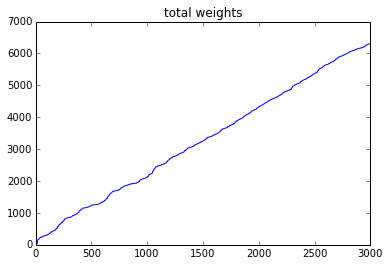

In [306]:
plt.plot(E)
plt.title('energy of the network')
plt.show()

plt.plot(E_input)
plt.title('energy of the stimulus')
plt.show()

plt.plot(E_total_log)
plt.title('total energy of the input')
plt.show()

plt.plot(weight_sum)
plt.title('total weights')
plt.show()

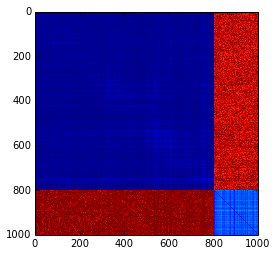

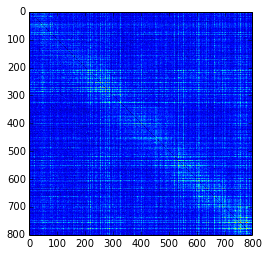

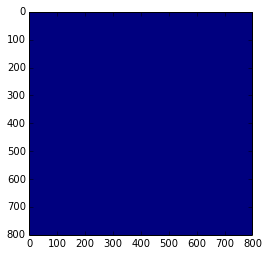

In [307]:

plt.imshow(W)
plt.show()
W3=W[:Ne,:Ne]
plt.imshow(W3)
plt.show()
W=np.zeros((Nt,Nt))
W3=W[:Ne,:Ne]

plt.imshow(W3)
plt.show()

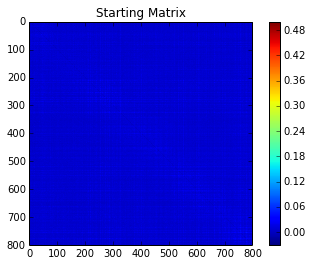

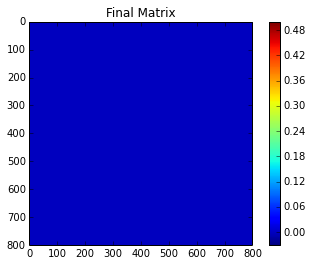

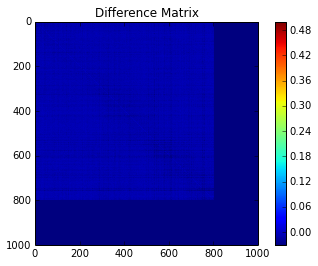

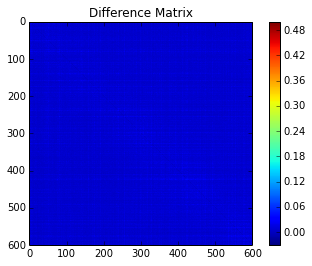

In [308]:
www=1
clim=(-.03,.5)

plt.imshow(W2save[www,:-200,:-200])
#plt.imshow(W_start[:-200,:-200])
plt.title('Starting Matrix')
plt.colorbar()
plt.clim( clim )
plt.show()

plt.imshow(W[:-200,:-200])
plt.title('Final Matrix')
plt.clim( clim )
plt.colorbar()
plt.show()

W_diff = W[:,:]-W2save[www,:,:]
plt.imshow(W_diff[:,:])
plt.title('Difference Matrix')
plt.colorbar()
plt.clim( clim )
plt.show()

W_diff = W2save[1,:-200,:-200]-W2save[4,:-200,:-200]
plt.imshow(W_diff[:-200,:-200])
plt.title('Difference Matrix')
plt.colorbar()
plt.clim( clim )
plt.show()

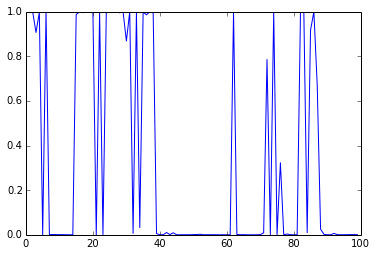

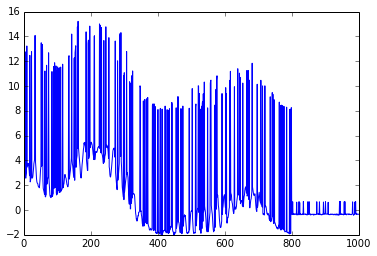

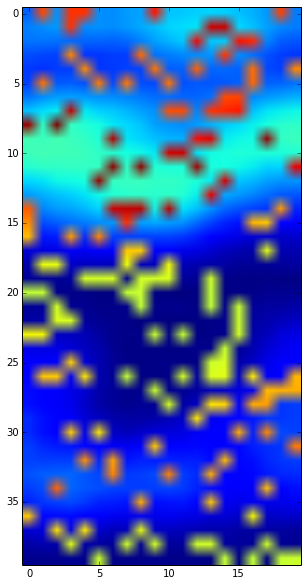

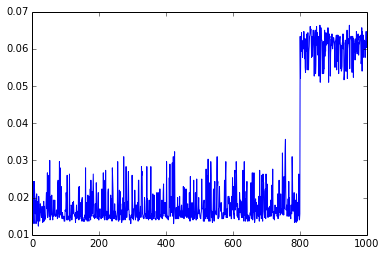

In [309]:
#Plot stimulus
plt.plot(stim)
plt.show()

#Plot stimulus transformed to current
plt.plot(I_in)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(np.hsplit(I_in[:-200],40),)
plt.show()

#Plot activity of network
meanDat = np.mean(spikeMat,axis=1)
img = meanDat[:-200].reshape( (Ne_x,Ne_y) )
plt.plot(meanDat)
#plt.imshow(img)


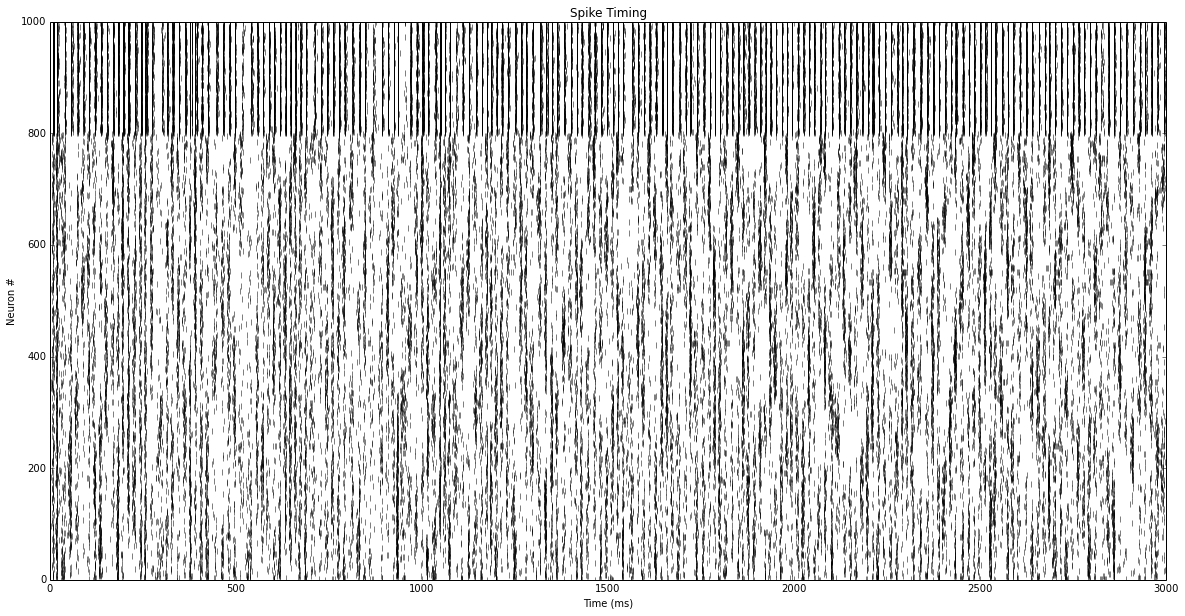

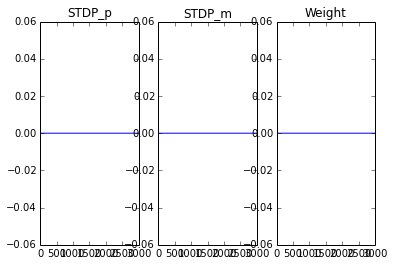

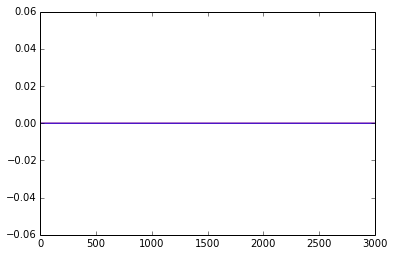

In [310]:
#plt.subplot(1,2,1)
plt.figure(figsize=(20,10))
rasterPlot=plt.plot(firings[0] , firings[1] , 'k|')
plt.axis([0, 3000, 0, 1000])
plt.ylabel('Neuron #')
plt.xlabel('Time (ms)')
plt.title('Spike Timing')
plt.show()

'''
plt.subplot(1,2,2)

n, bins = np.histogram(firings[0] , np.arange(0.,5000.,20.) )
plt.bar( bins[:-1] , n/(Nt*5.)*1000.)
#plt.bar( bins[:-1] , n)
plt.xlabel('Time (ms)')
plt.title('Firing Rate')

plt.show()
'''

plt.subplot(131)
plt.plot(stdp_neuron[:,0])
plt.title('STDP_p')

plt.subplot(132)
plt.plot(stdp_neuron[:,1])
plt.title('STDP_m')

plt.subplot(133)
plt.plot(stdp_neuron[:,2])
plt.title('Weight')

plt.show()

plt.plot(stdp_neuron[:,0],'r-')
plt.plot(stdp_neuron[:,1],'b-')


plt.savefig('queen.png', dpi=300)

In [192]:
## Plot receptive fields
#extract firing rate from neuron
def FR(firing,total_time,time_window,n_neurons):
    last_time = max(firing[0])
    neuron_rate=np.zeros((n_neurons,total_time/time_window))
    for step in range(total_time/time_window): #in ms
        #print step
        condition = firing[0]>=(step*time_window) 
        condition *= firing[0]<=((step+1)*time_window)
        f=firing[1][condition]
        #print f.size
        #f=firing[1][firing[0]>=step*time_window and firing[0]<=(step+1)*time_window]
        #print f
        
        for neuron in np.unique(firing[1]):
            neuron_rate[neuron,step]=np.sum(f==neuron)
            if neuron_rate[neuron,step] >1:
                print neuron_rate[neuron,step]
            #print np.sum(f==neuron)
        
    return neuron_rate



time_window=1
firing_rates=FR(firings,3000,time_window,1000)


'''
time_window=1
F=FR(firings,3000,time_window,1000)
plt.imshow(F/time_window, aspect='auto',interpolation='none')
plt.colorbar()
    '''

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0


KeyboardInterrupt: 

In [ ]:
#time_window = 1
sessions=np.array(range(time/2400))
print sessions
##Plot 
F=0 # session to evaluate
trial=(T)/time_window# Trial
offset=(off)/time_window# StimulusOnset
pl1=0
print T
print off
for session in sessions:
    session=sessions[0]
    pl1+=firing_rates[352,(session+F*trial+offset):(session+(F+1)*trial)] /trial
plt.title('pre')
plt.plot(pl1)
plt.show()

pl2=0
for session in sessions:
    session=sessions[1]
    pl2+=firing_rates[352,(session+F*trial+offset):(session+(F+1)*trial)] /trial
plt.title('post')
plt.plot(pl2)
plt.show()

pl3=0
for session in sessions:
    session=sessions[2]
    pl3+=firing_rates[362,(session+F*trial+offset):(session+(F+1)*trial)] /trial
plt.title('post')
plt.plot(pl3)
plt.show()

plt.plot(pl3)
plt.plot(pl2)
plt.plot(pl1)
plt.show()

plt.plot(firing_rates[352,:])

In [ ]:
#Scaling the matrix
W = (W**2)*4*0.8

In [ ]:
#Save W after 10 seconds of simulation w/ stdp w/o inhibition
W_stdp_10s = W
np.save('W_stdp_10s',W_stdp_10s)